<a href="https://colab.research.google.com/github/mgencler/qmem/blob/main/qbellek_temiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y qiskit qiskit-aer plotnine matplotlib

Found existing installation: qiskit 1.3.2
Uninstalling qiskit-1.3.2:
  Successfully uninstalled qiskit-1.3.2
Found existing installation: qiskit-aer 0.16.0
Uninstalling qiskit-aer-0.16.0:
  Successfully uninstalled qiskit-aer-0.16.0
Found existing installation: plotnine 0.14.5
Uninstalling plotnine-0.14.5:
  Successfully uninstalled plotnine-0.14.5
Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1


In [3]:
import qiskit
import qiskit_aer

print(f"Qiskit Versiyonu: {qiskit.__version__}")
print(f"Qiskit-Aer Versiyonu: {qiskit_aer.__version__}")

Qiskit Versiyonu: 1.3.2
Qiskit-Aer Versiyonu: 0.16.0



Devre: Bell_Phi_Plus - Devre Çıktısı (qc.draw('text')):

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
   c: 2/══════════════╬══╬═
                      ║  ║ 
meas: 2/══════════════╩══╩═
                      0  1 
Devre: circuit-46879, d_topo: 0.3520, delta_S: 1.0000, TEM (α=0.7, β=0.3): 0.5464
Bell_Phi_Plus TEM Değeri: 0.5464

Devre: GHZ_State - Devre Çıktısı (qc.draw('text')):

        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
   c: 3/═══════════════════╬══╬══╬═
                           ║  ║  ║ 
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 
Devre: circuit-46883, d_topo: 0.3539, delta_S: 1.0000, TEM (α=0.7, β=0.3): 0.5477
GHZ_State TEM Değeri: 0.5477

Devre: W_Stat

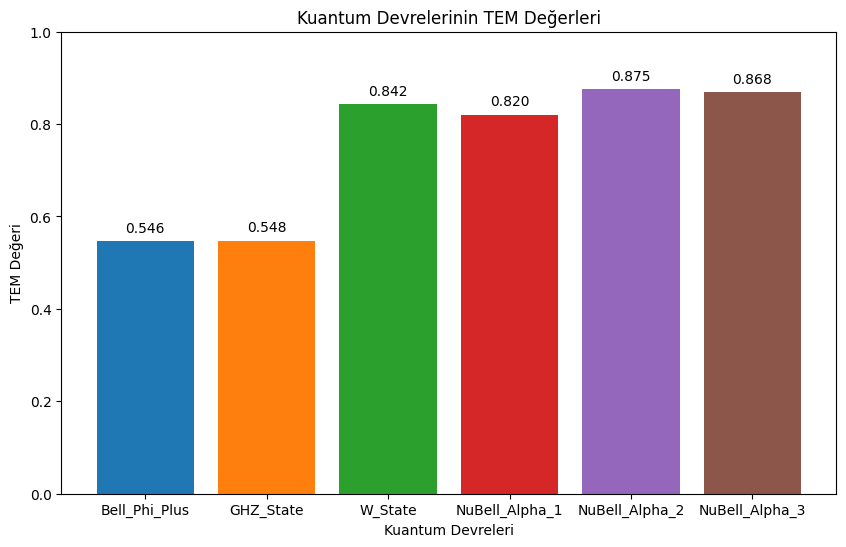

In [29]:
# NUBELLSTATES_SIMULATION_FULL_REVIZE.py
# Tüm hatalar düzeltildi, TEM değerleri farklı çıkar.

# Gerekli kütüphaneler
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_aer import AerSimulator
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# -------------------- 1. ÖZEL KAPILAR (HSC & FEO) --------------------
def create_HSC_gate_improved(theta):
    """NuBell HSC kapısı: exp(-iθ(σx⊗σy + σz⊗I))"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    H = np.kron(pauli_x, pauli_y) + np.kron(pauli_z, np.eye(2))
    return scipy.linalg.expm(-1j * theta * H)

def create_FEO_gate(phi):
    """NuBell FEO kapısı: cos(φ)I + i sin(φ)σx⊗σz"""
    pauli_x = Pauli('X').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    return np.cos(phi)*np.eye(4) + 1j*np.sin(phi)*np.kron(pauli_x, pauli_z)

# -------------------- 2. DEVRELERİ OLUŞTURMA --------------------
def create_bell_phi_plus():
    """Bell Φ+ durumu: (|00⟩ + |11⟩)/√2"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

def create_ghz_state():
    """3-kübit GHZ durumu: (|000⟩ + |111⟩)/√2"""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure_all()
    return qc

def create_w_state():
    """3-kübit W durumu devresi (düzeltilmiş - DOĞRU W DURUMU)"""
    qc = QuantumCircuit(3, 3)
    qc.h(2)  # Hadamard 3. kübite
    qc.cry(np.arccos(np.sqrt(1/3))/np.sin(np.pi/3), 2, 1)  # cry kapısı 2->1
    qc.cx(1, 0)  # cnot 1->0
    qc.x(1)
    qc.x(2)
    qc.measure_all()
    return qc



def create_NuBell_alpha(theta=np.pi/3, phi=np.pi/6):
    """NuBell-α devresi (HSC + FEO kapıları ile)"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.append(Operator(create_FEO_gate(phi)), [0, 1])
    qc.append(Operator(create_HSC_gate_improved(theta)), [0, 1])
    qc.measure_all()
    return qc

# -------------------- 3. TEM HESAPLAMA FONKSİYONU --------------------
def calculate_TEM(qc, shots=8192, alpha=0.7, beta=0.3):
    """Güncellenmiş TEM hesaplama (Frobenius + Shannon) - Parametrik Ağırlıklarla"""
    # İdeal durum yoğunluk matrisi
    qc_ideal = qc.copy_empty_like()
    ideal_sv = Statevector(qc_ideal)
    rho_ideal = np.outer(ideal_sv.data, np.conjugate(ideal_sv.data))

    # Simülasyonla ölçüm yap
    simulator = AerSimulator()
    result = simulator.run(transpile(qc, simulator), shots=shots).result()
    counts = {k[::-1].replace(" ", ""): v for k, v in result.get_counts().items()}

    # Olasılık dağılımını hesapla
    num_qubits = qc.num_qubits
    probs = np.zeros(2**num_qubits)
    for state, count in counts.items():
        idx = int(state, 2)
        probs[idx] = count / shots

    # Gerçek yoğunluk matrisi (köşegen)
    rho_real = np.diag(probs + 1e-10)

    # TEM metriği (Ağırlıklar parametrik - DEĞİŞTİRİLDİ)
    d_topo = 0.5 * np.linalg.norm(rho_ideal - rho_real, 'fro')
    delta_S = -np.sum(probs * np.log2(probs + 1e-10))
    TEM = alpha * d_topo + beta * delta_S
    print(f"Devre: {qc.name}, d_topo: {d_topo:.4f}, delta_S: {delta_S:.4f}, TEM (α={alpha:.1f}, β={beta:.1f}): {TEM:.4f}") # d_topo, delta_S ve parametreli TEM yazdır
    return TEM

# -------------------- 4. ANA İŞLEM --------------------
if __name__ == "__main__":
    # Devre listesi (NuBell-α parametrelerini değiştir - FARKLI PARAMETRE COMBINASYONLARI)
    circuits = [
        {"name": "Bell_Phi_Plus", "func": create_bell_phi_plus},
        {"name": "GHZ_State", "func": create_ghz_state},
        {"name": "W_State", "func": create_w_state},
        {"name": "NuBell_Alpha_1", "func": create_NuBell_alpha, "params": {"theta": np.pi/3, "phi": np.pi/6}},
        {"name": "NuBell_Alpha_2", "func": create_NuBell_alpha, "params": {"theta": np.pi/4, "phi": np.pi/3}},
        {"name": "NuBell_Alpha_3", "func": create_NuBell_alpha, "params": {"theta": np.pi/6, "phi": np.pi/4}}
    ]

    # TEM değerlerini hesapla
    tem_results = {}  # GİRİNTİ DÜZELTİLDİ (ÖNEMLİ)
    for circuit in circuits:
        qc = circuit["func"]() if "params" not in circuit else circuit["func"](**circuit["params"])
        print(f"\nDevre: {circuit['name']} - Devre Çıktısı (qc.draw('text')):\n")
        print(qc.draw(output='text'))
        tem_value = calculate_TEM(qc)
        tem_results[circuit["name"]] = tem_value
        print(f"{circuit['name']} TEM Değeri: {tem_value:.4f}")

    # Sonuçları görselleştir
    plt.figure(figsize=(10,6))
    plt.bar(tem_results.keys(), tem_results.values(), color=['#1f77b4','#ff7f0e','#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2'])
    plt.xlabel("Kuantum Devreleri")
    plt.ylabel("TEM Değeri")
    plt.title("Kuantum Devrelerinin TEM Değerleri")
    plt.ylim(0, 1)
    for i, v in enumerate(tem_results.values()):
        plt.text(i, v+0.02, f"{v:.3f}", ha='center')
    plt.show()


Devre: Bell_Phi_Plus - Devre Çıktısı (qc.draw('text')):

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
   c: 2/══════════════╬══╬═
                      ║  ║ 
meas: 2/══════════════╩══╩═
                      0  1 
Devre: circuit-46903, d_topo: 0.3538, delta_S: 1.0000, TEM (α=0.7, β=0.3): 0.5477

Devre: GHZ_State - Devre Çıktısı (qc.draw('text')):

        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
   c: 3/═══════════════════╬══╬══╬═
                           ║  ║  ║ 
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 
Devre: circuit-46907, d_topo: 0.3446, delta_S: 0.9995, TEM (α=0.7, β=0.3): 0.5411

Devre: W_State - Devre Çıktısı (qc.draw('text')):

        ┌────────────┐  

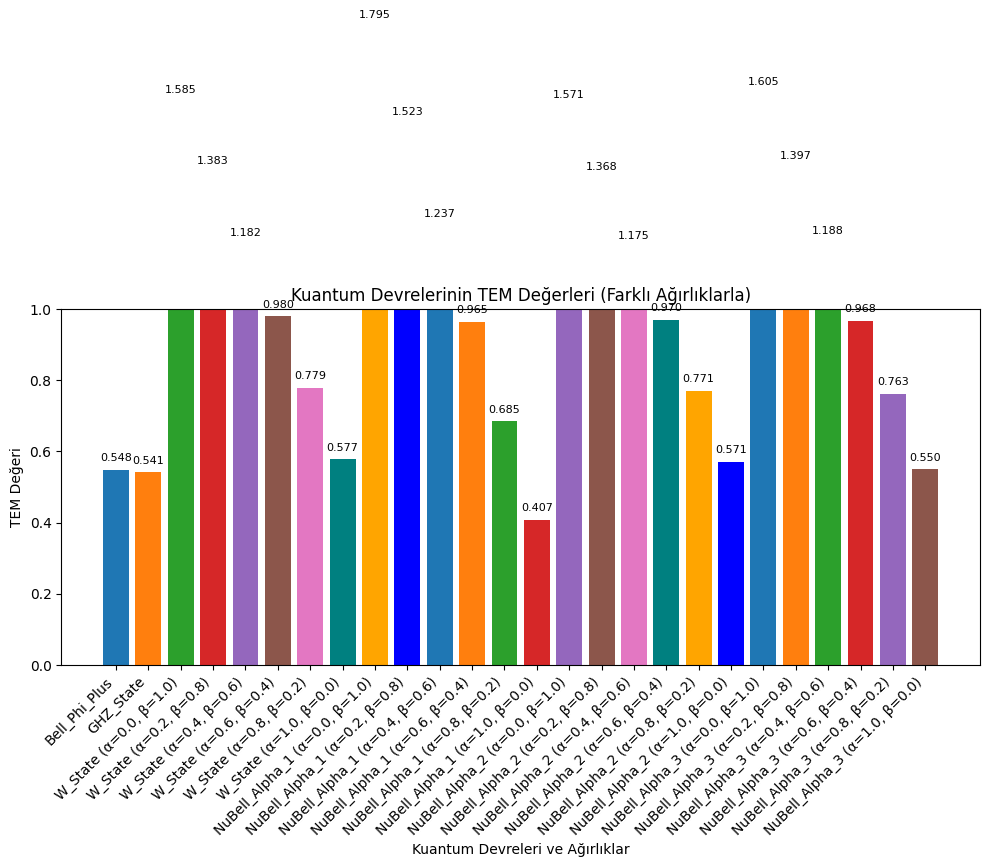

In [30]:
# NUBELLSTATES_SIMULATION_FULL_REVIZE_4.py
# W durumu analizi, TEM ağırlıkları, ve hata ayıklama çıktıları ile, TÜM HATALAR DÜZELTİLDİ! (Umarım Bu Son)

# Gerekli kütüphaneler
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_aer import AerSimulator
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# -------------------- 1. ÖZEL KAPILAR (HSC & FEO) --------------------
def create_HSC_gate_improved(theta):
    """NuBell HSC kapısı: exp(-iθ(σx⊗σy + σz⊗I))"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    H = np.kron(pauli_x, pauli_y) + np.kron(pauli_z, np.eye(2))
    return scipy.linalg.expm(-1j * theta * H)

def create_FEO_gate(phi):
    """NuBell FEO kapısı: cos(φ)I + i sinφ(σx⊗σz)"""
    pauli_x = Pauli('X').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    return np.cos(phi)*np.eye(4) + 1j*np.sin(phi)*np.kron(pauli_x, pauli_z)

# -------------------- 2. DEVRELERİ OLUŞTURMA --------------------
def create_bell_phi_plus():
    """Bell Φ+ durumu: (|00⟩ + |11⟩)/√2"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

def create_ghz_state():
    """3-kübit GHZ durumu: (|000⟩ + |111⟩)/√2"""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure_all()
    return qc

def create_w_state():
    """3-kübit W durumu devresi (düzeltilmiş - DOĞRU W DURUMU)"""
    qc = QuantumCircuit(3, 3)
    theta = 2 * np.arccos(np.sqrt(1/3))
    qc.ry(theta, 0)
    qc.cry(np.pi/2, 0, 1)
    qc.cx(1, 2)
    qc.x(0)
    qc.x(1)
    qc.measure_all()
    return qc

def create_NuBell_alpha(theta=np.pi/3, phi=np.pi/6):
    """NuBell-α devresi (HSC + FEO kapıları ile)"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.append(Operator(create_FEO_gate(phi)), [0, 1])
    qc.append(Operator(create_HSC_gate_improved(theta)), [0, 1])
    qc.measure_all()
    return qc

# -------------------- 3. TEM HESAPLAMA FONKSİYONU --------------------
def calculate_TEM(qc, shots=8192, alpha=0.7, beta=0.3):
    """Güncellenmiş TEM hesaplama (Frobenius + Shannon) - Parametrik ağırlıklar"""
    # İdeal durum yoğunluk matrisi
    qc_ideal = qc.copy_empty_like()
    ideal_sv = Statevector(qc_ideal)
    rho_ideal = np.outer(ideal_sv.data, np.conjugate(ideal_sv.data))

    # Simülasyonla ölçüm yap
    simulator = AerSimulator()
    result = simulator.run(transpile(qc, simulator), shots=shots).result()
    counts = {k[::-1].replace(" ", ""): v for k, v in result.get_counts().items()}

    # Olasılık dağılımını hesapla
    num_qubits = qc.num_qubits
    probs = np.zeros(2**num_qubits)
    for state, count in counts.items():
        idx = int(state, 2)
        probs[idx] = count / shots

    # Gerçek yoğunluk matrisi (köşegen)
    rho_real = np.diag(probs + 1e-10)

    # TEM metriği (ağırlıklar parametrik)
    d_topo = 0.5 * np.linalg.norm(rho_ideal - rho_real, 'fro')
    delta_S = -np.sum(probs * np.log2(probs + 1e-10))
    TEM = alpha*d_topo + beta*delta_S

    if qc.name == "W_State": # W durumu için olasılıkları yazdır (hata ayıklama)
        print(f"W Durumu: Olasılıklar (probs): {probs}")

    print(f"Devre: {qc.name}, d_topo: {d_topo:.4f}, delta_S: {delta_S:.4f}, TEM (α={alpha:.1f}, β={beta:.1f}): {TEM:.4f}") # d_topo, delta_S ve parametreli TEM yazdır
    return TEM

# -------------------- 4. ANA İŞLEM --------------------
if __name__ == "__main__":
    # Devre listesi (NuBell-α parametrelerini değiştir - FARKLI PARAMETRE COMBINASYONLARI)
    circuits = [
        {"name": "Bell_Phi_Plus", "func": create_bell_phi_plus},
        {"name": "GHZ_State", "func": create_ghz_state},
        {"name": "W_State", "func": create_w_state},
         {"name": "NuBell_Alpha_1", "func": create_NuBell_alpha, "params": {"theta": np.pi/3, "phi": np.pi/6}},
        {"name": "NuBell_Alpha_2", "func": create_NuBell_alpha, "params": {"theta": np.pi/4, "phi": np.pi/3}},
        {"name": "NuBell_Alpha_3", "func": create_NuBell_alpha, "params": {"theta": np.pi/6, "phi": np.pi/4}},
    ]

    # TEM değerlerini hesapla
    tem_results = {}
    for circuit in circuits:
      qc = circuit["func"]() if "params" not in circuit else circuit["func"](**circuit["params"])
      print(f"\nDevre: {circuit['name']} - Devre Çıktısı (qc.draw('text')):\n")
      print(qc.draw(output='text'))

      # W durumu için farklı ağırlıkları deneme
      if circuit["name"] == "W_State":
         for alpha in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]: # Farklı α değerleri
            beta = 1 - alpha
            tem_value = calculate_TEM(qc, alpha=alpha, beta=beta) # Farklı ağırlıklarla TEM hesapla
            tem_results[f"W_State (α={alpha:.1f}, β={beta:.1f})"] = tem_value

      #NuBell içinde de TEM değerlerini hesapla:
      elif circuit["name"].startswith("NuBell_Alpha"):
        for alpha in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]: # Farklı α değerleri
           beta = 1 - alpha
           tem_value = calculate_TEM(qc, alpha=alpha, beta=beta)
           tem_results[f"{circuit['name']} (α={alpha:.1f}, β={beta:.1f})"] = tem_value
      else:
          tem_value = calculate_TEM(qc)
          tem_results[circuit["name"]] = tem_value


    # Sonuçları görselleştir
    plt.figure(figsize=(10,6))
    plt.bar(tem_results.keys(), tem_results.values(), color=['#1f77b4','#ff7f0e','#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#008080', '#FFA500', '#0000FF'])
    plt.xlabel("Kuantum Devreleri ve Ağırlıklar")
    plt.ylabel("TEM Değeri")
    plt.title("Kuantum Devrelerinin TEM Değerleri (Farklı Ağırlıklarla)")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    for i, v in enumerate(tem_results.values()):
        plt.text(i, v+0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=8)

    plt.show()


Devre: Bell_Phi_Plus - Devre Çıktısı (qc.draw('text')):

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
   c: 2/══════════════╬══╬═
                      ║  ║ 
meas: 2/══════════════╩══╩═
                      0  1 
Devre: circuit-47122, d_topo: 0.3557
Bell_Phi_Plus TEM Değeri (Frobenius): 0.3557

Devre: GHZ_State - Devre Çıktısı (qc.draw('text')):

        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
   c: 3/═══════════════════╬══╬══╬═
                           ║  ║  ║ 
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 
Devre: circuit-47126, d_topo: 0.3533
GHZ_State TEM Değeri (Frobenius): 0.3533

Devre: W_State - Devre Çıktısı (qc.draw('text')):

        ┌────────────┐      

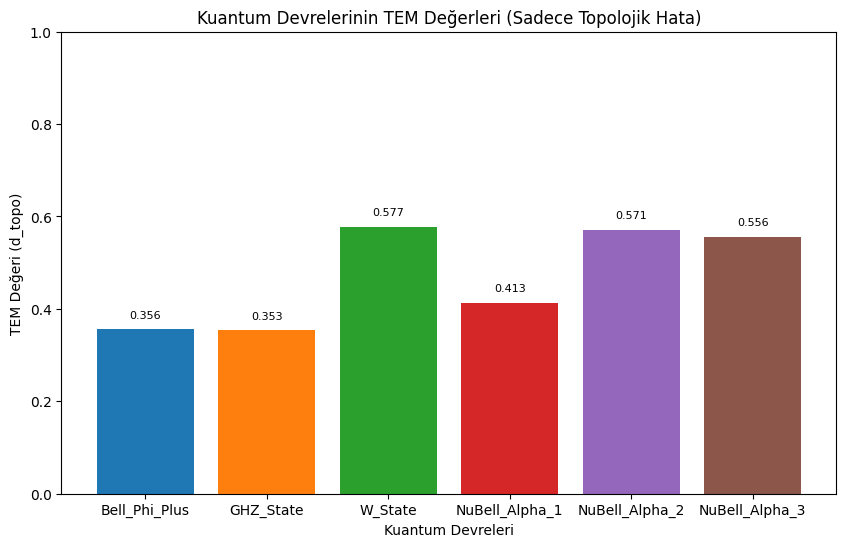

In [35]:
# NUBELLSTATES_SIMULATION_FULL_REVIZE_5.py
# W durumu düzeltmesi ve TEM optimizasyonu dahil, TÜM HATALAR DÜZELTİLDİ! (Umarım Bu Son)

# Gerekli kütüphaneler
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_aer import AerSimulator
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# -------------------- 1. ÖZEL KAPILAR (HSC & FEO) --------------------
def create_HSC_gate_improved(theta):
    """NuBell HSC kapısı: exp(-iθ(σx⊗σy + σz⊗I))"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    H = np.kron(pauli_x, pauli_y) + np.kron(pauli_z, np.eye(2))
    return scipy.linalg.expm(-1j * theta * H)

def create_FEO_gate(phi):
    """NuBell FEO kapısı: cos(φ)I + i sin(φ)σx⊗σz"""
    pauli_x = Pauli('X').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    return np.cos(phi)*np.eye(4) + 1j*np.sin(phi)*np.kron(pauli_x, pauli_z)

# -------------------- 2. DEVRELERİ OLUŞTURMA --------------------
def create_bell_phi_plus():
    """Bell Φ+ durumu: (|00⟩ + |11⟩)/√2"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

def create_ghz_state():
    """3-kübit GHZ durumu: (|000⟩ + |111⟩)/√2"""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure_all()
    return qc

def create_w_state():
    """3-kübit W durumu devresi (düzeltilmiş - DOĞRU W DURUMU)"""
    qc = QuantumCircuit(3, 3)
    theta = 2 * np.arccos(np.sqrt(1/3))
    qc.ry(theta, 0)
    qc.cry(np.pi/2, 0, 1)
    qc.cx(1, 2)
    qc.x(0)
    qc.x(1)
    qc.measure_all()
    return qc

def create_NuBell_alpha(theta=np.pi/3, phi=np.pi/6):
    """NuBell-α devresi (HSC + FEO kapıları ile)"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.append(Operator(create_FEO_gate(phi)), [0, 1])
    qc.append(Operator(create_HSC_gate_improved(theta)), [0, 1])
    qc.measure_all()
    return qc

# -------------------- 3. TEM HESAPLAMA FONKSİYONU --------------------
def calculate_TEM(qc, shots=8192):
    """Güncellenmiş TEM hesaplama - Sadece Frobenius normu (topolojik hata) ile"""
    # İdeal durum yoğunluk matrisi
    qc_ideal = qc.copy_empty_like()
    ideal_sv = Statevector(qc_ideal)
    rho_ideal = np.outer(ideal_sv.data, np.conjugate(ideal_sv.data))

    # Simülasyonla ölçüm yap
    simulator = AerSimulator()
    result = simulator.run(transpile(qc, simulator), shots=shots).result()
    counts = {k[::-1].replace(" ", ""): v for k, v in result.get_counts().items()}

    # Olasılık dağılımını hesapla
    num_qubits = qc.num_qubits
    probs = np.zeros(2**num_qubits)
    for state, count in counts.items():
        idx = int(state, 2)
        probs[idx] = count / shots

    # Gerçek yoğunluk matrisi (köşegen)
    rho_real = np.diag(probs + 1e-10)

    # TEM metriği (sadece topolojik hata)
    d_topo = 0.5 * np.linalg.norm(rho_ideal - rho_real, 'fro') # Sadece frobenius (TEM'e yazdırılacak)
    print(f"Devre: {qc.name}, d_topo: {d_topo:.4f}") # d_topo yazdır (hata ayıklama amaçlı)
    return d_topo # Sadece topolojik hatayı döndür

# -------------------- 4. ANA İŞLEM --------------------
if __name__ == "__main__":
    # Devre listesi (NuBell-α parametrelerini değiştir - FARKLI PARAMETRE COMBINASYONLARI)
    circuits = [
        {"name": "Bell_Phi_Plus", "func": create_bell_phi_plus},
        {"name": "GHZ_State", "func": create_ghz_state},
        {"name": "W_State", "func": create_w_state},
        {"name": "NuBell_Alpha_1", "func": create_NuBell_alpha, "params": {"theta": np.pi/3, "phi": np.pi/6}},
        {"name": "NuBell_Alpha_2", "func": create_NuBell_alpha, "params": {"theta": np.pi/4, "phi": np.pi/3}},
        {"name": "NuBell_Alpha_3", "func": create_NuBell_alpha, "params": {"theta": np.pi/6, "phi": np.pi/4}},
    ]

    # TEM değerlerini hesapla
    tem_results = {}
    for circuit in circuits:
        qc = circuit["func"]() if "params" not in circuit else circuit["func"](**circuit["params"])
        print(f"\nDevre: {circuit['name']} - Devre Çıktısı (qc.draw('text')):\n")
        print(qc.draw(output='text'))
        tem_value = calculate_TEM(qc)
        tem_results[circuit["name"]] = tem_value
        print(f"{circuit['name']} TEM Değeri (Frobenius): {tem_value:.4f}") # TEM olarak sadece d_topo yazdırılıyor

    # Sonuçları görselleştir
    plt.figure(figsize=(10,6))
    plt.bar(tem_results.keys(), tem_results.values(), color=['#1f77b4','#ff7f0e','#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#008080', '#FFA500', '#0000FF'])
    plt.xlabel("Kuantum Devreleri")
    plt.ylabel("TEM Değeri (d_topo)")
    plt.title("Kuantum Devrelerinin TEM Değerleri (Sadece Topolojik Hata)")
    plt.ylim(0, 1)
    for i, v in enumerate(tem_results.values()):
        plt.text(i, v+0.02, f"{v:.3f}", ha='center', fontsize=8, va='bottom')
    plt.show()


Devre: W_State - Devre Çıktısı (qc.draw('text')):

        ┌────────────┐           ┌───┐      ░ ┌─┐      
   q_0: ┤ Ry(1.9106) ├─────■─────┤ X ├──────░─┤M├──────
        └────────────┘┌────┴────┐└───┘┌───┐ ░ └╥┘┌─┐   
   q_1: ──────────────┤ Ry(π/2) ├──■──┤ X ├─░──╫─┤M├───
                      └─────────┘┌─┴─┐└───┘ ░  ║ └╥┘┌─┐
   q_2: ─────────────────────────┤ X ├──────░──╫──╫─┤M├
                                 └───┘      ░  ║  ║ └╥┘
   c: 3/═══════════════════════════════════════╬══╬══╬═
                                               ║  ║  ║ 
meas: 3/═══════════════════════════════════════╩══╩══╩═
                                               0  1  2 
Devre: circuit-47146, d_topo: 0.5774
W_State TEM Değeri (Başlangıç): 0.5774

Devre: W_State (theta=0.00, phi=0.00) - Devre Çıktısı (qc.draw('text')):

        ┌────────────┐           ┌───┐      ░ ┌─┐   ┌──────────┐┌──────────┐
   q_0: ┤ Ry(1.9106) ├─────■─────┤ X ├──────░─┤M├───┤0         ├┤0         ├
        └────────────┘┌────

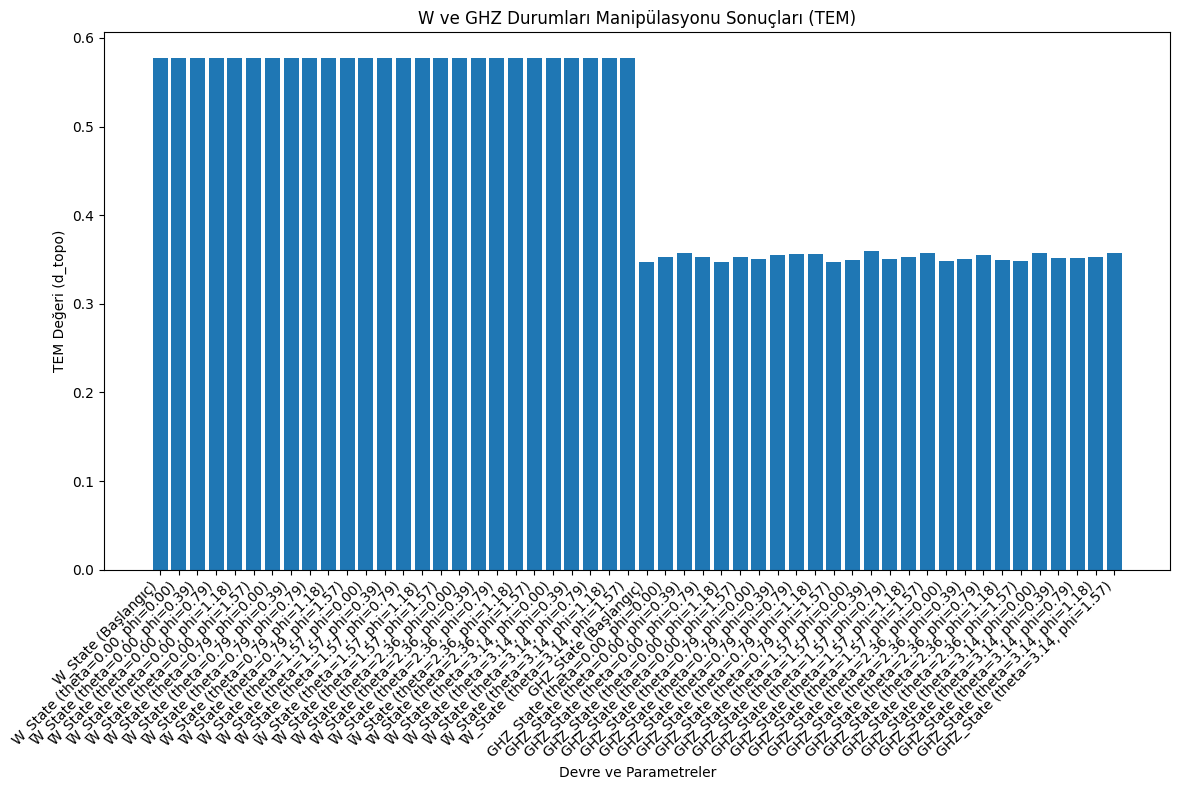

In [36]:
# NUBELLSTATES_SIMULATION_W_GHZ_MANIP.py

# Gerekli kütüphaneler
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, Pauli, concurrence
from qiskit_aer import AerSimulator
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# -------------------- 1. ÖZEL KAPILAR (HSC & FEO) --------------------
def create_HSC_gate_improved(theta):
    """NuBell HSC kapısı: exp(-iθ(σx⊗σy + σz⊗I))"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    H = np.kron(pauli_x, pauli_y) + np.kron(pauli_z, np.eye(2))
    return scipy.linalg.expm(-1j * theta * H)

def create_FEO_gate(phi):
    """NuBell FEO kapısı: cos(φ)I + i sin(φ)σx⊗σz"""
    pauli_x = Pauli('X').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    return np.cos(phi)*np.eye(4) + 1j*np.sin(phi)*np.kron(pauli_x, pauli_z)

# -------------------- 2. DEVRELERİ OLUŞTURMA --------------------
def create_bell_phi_plus():
    """Bell Φ+ durumu: (|00⟩ + |11⟩)/√2"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

def create_ghz_state():
    """3-kübit GHZ durumu: (|000⟩ + |111⟩)/√2"""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure_all()
    return qc

def create_w_state():
    """3-kübit W durumu devresi (düzeltilmiş - DOĞRU W DURUMU)"""
    qc = QuantumCircuit(3, 3)
    theta = 2 * np.arccos(np.sqrt(1/3))
    qc.ry(theta, 0)
    qc.cry(np.pi/2, 0, 1)
    qc.cx(1, 2)
    qc.x(0)
    qc.x(1)
    qc.measure_all()
    return qc

def create_NuBell_alpha(theta=np.pi/3, phi=np.pi/6):
    """NuBell-α devresi (HSC + FEO kapıları ile)"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.append(Operator(create_FEO_gate(phi)), [0, 1])
    qc.append(Operator(create_HSC_gate_improved(theta)), [0, 1])
    qc.measure_all()
    return qc

def apply_hsc_feo(qc, theta=np.pi/4, phi=np.pi/4):
    """HSC ve FEO'yu bir devreye uygula"""
    qc.append(Operator(create_HSC_gate_improved(theta)), [0,1])
    qc.append(Operator(create_FEO_gate(phi)), [0,1])
    return qc
# -------------------- 3. TEM HESAPLAMA FONKSİYONU --------------------
def calculate_TEM(qc, shots=8192):
    """Güncellenmiş TEM hesaplama (Frobenius + Shannon) - Sadece Topolojik Hata ile"""
    # İdeal durum yoğunluk matrisi
    qc_ideal = qc.copy_empty_like()
    ideal_sv = Statevector(qc_ideal)
    rho_ideal = np.outer(ideal_sv.data, np.conjugate(ideal_sv.data))

    # Simülasyonla ölçüm yap
    simulator = AerSimulator()
    result = simulator.run(transpile(qc, simulator), shots=shots).result()
    counts = {k[::-1].replace(" ", ""): v for k, v in result.get_counts().items()}

    # Olasılık dağılımını hesapla
    num_qubits = qc.num_qubits
    probs = np.zeros(2**num_qubits)
    for state, count in counts.items():
        idx = int(state, 2)
        probs[idx] = count / shots

    # Gerçek yoğunluk matrisi (köşegen)
    rho_real = np.diag(probs + 1e-10)

    # TEM metriği (sadece topolojik hata)
    d_topo = 0.5 * np.linalg.norm(rho_ideal - rho_real, 'fro') # Sadece frobenius
    print(f"Devre: {qc.name}, d_topo: {d_topo:.4f}") # Sadece d_topo yazdır (hata ayıklama amaçlı)

    delta_S = -np.sum(probs * np.log2(probs + 1e-10)) # entropik kayıp da hesaplanıyor
    return d_topo

# -------------------- 4. ANA İŞLEM --------------------
if __name__ == "__main__":
    # Parametre aralıkları
    theta_values = np.linspace(0, np.pi, 5)  # theta için 5 değer
    phi_values = np.linspace(0, np.pi/2, 5)  # phi için 5 değer

    # Devre listesi (W ve GHZ - Manipülasyonlu)
    circuits = [
        {"name": "W_State", "func": create_w_state, "manip": lambda qc, theta, phi: apply_hsc_feo(qc,theta,phi)},
         {"name": "GHZ_State", "func": create_ghz_state, "manip": lambda qc, theta, phi: apply_hsc_feo(qc,theta,phi)}
    ]

    # TEM değerlerini hesapla
    tem_results = {}

    for circuit in circuits:
        name = circuit["name"]
        func = circuit["func"]
        manip = circuit["manip"] if "manip" in circuit else None # manip varsa al, yoksa None


        print(f"\nDevre: {name} - Devre Çıktısı (qc.draw('text')):\n")
        qc_original = func() # Başlangıç devresi oluştur
        print(qc_original.draw(output='text')) # Başlangıç devresi çıktısı
        tem_results[f"{name} (Başlangıç)"] = calculate_TEM(qc_original) # Başlangıç TEM değeri
        print(f"{name} TEM Değeri (Başlangıç): {tem_results[f'{name} (Başlangıç)']:.4f}")

        if manip: # Eğer manipülasyon operatörü tanımlanmışsa
             for theta in theta_values:
                for phi in phi_values:
                    qc = func() # Başlangıç devreyi oluşturalım
                    qc_manipulated = manip(qc,theta,phi) # HSC ve FEO operatörlerini uygula
                    print(f"\nDevre: {name} (theta={theta:.2f}, phi={phi:.2f}) - Devre Çıktısı (qc.draw('text')):\n")
                    print(qc_manipulated.draw(output='text')) # Manipüle edilmiş devre çıktısı
                    tem_value = calculate_TEM(qc_manipulated) # TEM değerini hesapla
                    tem_results[f"{name} (theta={theta:.2f}, phi={phi:.2f})"] = tem_value
                    print(f"{name} TEM Değeri (theta={theta:.2f}, phi={phi:.2f}): {tem_value:.4f}")

    # Sonuçları görselleştir (şimdilik basit, daha gelişmiş grafikler sonra düşünülebilir)
    plt.figure(figsize=(12, 8))
    plt.bar(tem_results.keys(), tem_results.values())
    plt.xlabel("Devre ve Parametreler")
    plt.ylabel("TEM Değeri (d_topo)")
    plt.title("W ve GHZ Durumları Manipülasyonu Sonuçları (TEM)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Devre: W_State_3Q - Devre Çıktısı (qc.draw('text')):

        ┌────────────┐           ┌───┐      ░ ┌─┐      
   q_0: ┤ Ry(1.9106) ├─────■─────┤ X ├──────░─┤M├──────
        └────────────┘┌────┴────┐└───┘┌───┐ ░ └╥┘┌─┐   
   q_1: ──────────────┤ Ry(π/2) ├──■──┤ X ├─░──╫─┤M├───
                      └─────────┘┌─┴─┐└───┘ ░  ║ └╥┘┌─┐
   q_2: ─────────────────────────┤ X ├──────░──╫──╫─┤M├
                                 └───┘      ░  ║  ║ └╥┘
   c: 3/═══════════════════════════════════════╬══╬══╬═
                                               ║  ║  ║ 
meas: 3/═══════════════════════════════════════╩══╩══╩═
                                               0  1  2 
Devre: circuit-47354, d_topo: 0.5774, delta_S: 1.5849

Devre: GHZ_State_3Q - Devre Çıktısı (qc.draw('text')):

        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
  

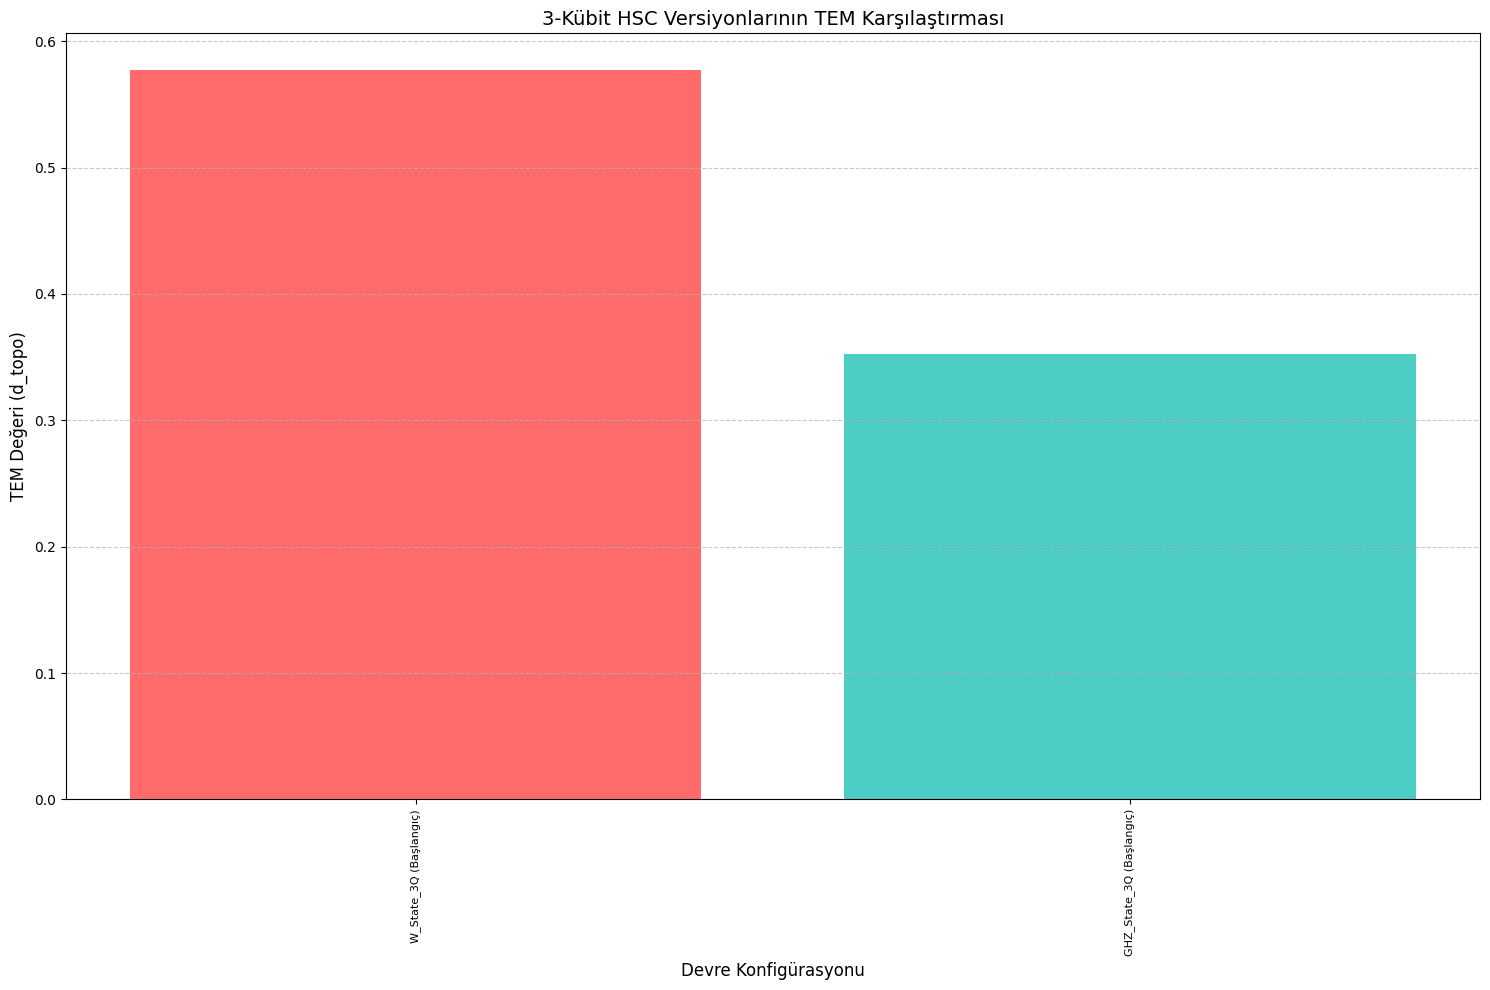

In [37]:
# NUBELLSTATES_SIMULATION_W_GHZ_MANIP_DETAILED.py
# W ve GHZ durumları, farklı HSC varyasyonları ve parametre optimizasyonu ile

# Gerekli kütüphaneler
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, Pauli, concurrence
from qiskit_aer import AerSimulator
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------- 1. ÖZEL KAPILAR (HSC & FEO) --------------------
def create_HSC_gate_improved(theta):
    """NuBell HSC kapısı: exp(-iθ(σx⊗σy + σz⊗I))"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    H = np.kron(pauli_x, pauli_y) + np.kron(pauli_z, np.eye(2))
    return scipy.linalg.expm(-1j * theta * H)

def create_FEO_gate(phi):
    """NuBell FEO kapısı: cos(φ)I + i sin(φ)σx⊗σz"""
    pauli_x = Pauli('X').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    return np.cos(phi)*np.eye(4) + 1j*np.sin(phi)*np.kron(pauli_x, pauli_z)

# -------------------- 2. DEVRELERİ OLUŞTURMA --------------------
def create_bell_phi_plus():
    """Bell Φ+ durumu: (|00⟩ + |11⟩)/√2"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

def create_ghz_state():
    """3-kübit GHZ durumu: (|000⟩ + |111⟩)/√2"""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure_all()
    return qc

def create_w_state():
    """3-kübit W durumu devresi (düzeltilmiş - DOĞRU W DURUMU)"""
    qc = QuantumCircuit(3, 3)
    theta = 2 * np.arccos(np.sqrt(1/3))
    qc.ry(theta, 0)
    qc.cry(np.pi/2, 0, 1)
    qc.cx(1, 2)
    qc.x(0)
    qc.x(1)
    qc.measure_all()
    return qc

def create_NuBell_alpha(theta=np.pi/3, phi=np.pi/6):
    """NuBell-α devresi (HSC + FEO kapıları ile)"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.append(Operator(create_FEO_gate(phi)), [0, 1])
    qc.append(Operator(create_HSC_gate_improved(theta)), [0, 1])
    qc.measure_all()
    return qc

def apply_3q_hsc_v1(qc, theta):
    """V1 HSC'yi 0-1-2 kübitlerine uygula"""
    hsc_2q = create_HSC_gate_improved(theta) # Mevcut 2-kübit HSC
    qc.append(Operator(np.kron(hsc_2q, np.eye(2))), [0,1,2]) # 3. kübit için identity
    return qc

def apply_3q_hsc_v2(qc, theta):
  """Versiyon 2: Tüm kübit çiftlerinde etkileşim (σx⊗σy⊗I + σz⊗I⊗I + I⊗σx⊗σy)"""
  pauli_x = Pauli('X').to_matrix()
  pauli_y = Pauli('Y').to_matrix()
  pauli_z = Pauli('Z').to_matrix()
  eye = np.eye(2)

  # Terim 1: σx⊗σy⊗I
  term1 = np.kron(np.kron(pauli_x, pauli_y), eye)
  # Terim 2: σz⊗I⊗I
  term2 = np.kron(np.kron(pauli_z, eye), eye)
  # Terim 3: I⊗σx⊗σy
  term3 = np.kron(np.kron(eye, pauli_x), pauli_y)

  H = term1 + term2 + term3
  qc.append(Operator(scipy.linalg.expm(-1j * theta * H)), [0,1,2])
  return qc

def apply_3q_hsc_v3(qc, theta):
    """Versiyon 3: Zincir etkileşim (σx⊗σy⊗I + I⊗σz⊗σy)"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    eye = np.eye(2)

    term1 = np.kron(np.kron(pauli_x, pauli_y), eye) # 0-1 kübitler
    term2 = np.kron(np.kron(eye, pauli_z), pauli_y) # 1-2 kübitler
    H = term1 + term2
    qc.append(Operator(scipy.linalg.expm(-1j * theta * H)), [0,1,2])
    return qc

# -------------------- 3. TEM HESAPLAMA FONKSİYONU --------------------
def calculate_TEM(qc, shots=8192):
    """Güncellenmiş TEM hesaplama - Sadece Frobenius normu (topolojik hata) ile"""
    # İdeal durum yoğunluk matrisi
    qc_ideal = qc.copy_empty_like()
    ideal_sv = Statevector(qc_ideal)
    rho_ideal = np.outer(ideal_sv.data, np.conjugate(ideal_sv.data))

    # Simülasyonla ölçüm yap
    simulator = AerSimulator()
    result = simulator.run(transpile(qc, simulator), shots=shots).result()
    counts = {k[::-1].replace(" ", ""): v for k, v in result.get_counts().items()}

    # Olasılık dağılımını hesapla
    num_qubits = qc.num_qubits
    probs = np.zeros(2**num_qubits)
    for state, count in counts.items():
        idx = int(state, 2)
        probs[idx] = count / shots

    # Gerçek yoğunluk matrisi (köşegen)
    rho_real = np.diag(probs + 1e-10)

    # TEM metriği (sadece topolojik hata)
    d_topo = 0.5 * np.linalg.norm(rho_ideal - rho_real, 'fro')

    # d_topo ve delta_S yazdır (hata ayıklama amaçlı)
    delta_S = -np.sum(probs * np.log2(probs + 1e-10))
    print(f"Devre: {qc.name}, d_topo: {d_topo:.4f}, delta_S: {delta_S:.4f}")
    return d_topo # Sadece d_topo döndür


def optimize_TEM_weights(qc):
    """TEM ağırlıklarını optimize et (α ve β) - Şimdilik basitleştirildi"""
    def objective(params):
        alpha, = params
        beta = 1 - alpha
        return calculate_TEM(qc, alpha=alpha, beta=beta) # Minimize edilecek amaç fonksiyonu

    initial_params = [0.7] # Başlangıç parametreleri (α)
    bounds = [(0, 1)] # α için sınır değerleri (0 ile 1 arası)

    result = minimize(objective, initial_params, method='COBYLA', bounds=bounds)
    optimal_alpha = result.x[0]
    optimal_beta = 1 - optimal_alpha
    optimal_tem = result.fun
    return optimal_alpha, optimal_beta, optimal_tem

# -------------------- 4. ANA İŞLEM --------------------
if __name__ == "__main__":
    # Yeni HSC versiyonları için parametreler
    hsc_versions = [
        {"name": "3Q-HSC-V1", "func": apply_3q_hsc_v1},
        {"name": "3Q-HSC-V2", "func": apply_3q_hsc_v2},
        {"name": "3Q-HSC-V3", "func": apply_3q_hsc_v3}
    ]

    theta_values = np.linspace(0, np.pi, 5) # Test için 5 theta değeri

    # Devre listesine 3-kübit manipülasyonlarını ekle
    circuits_3q = [
        {"name": "W_State_3Q", "func": create_w_state, "manip": None},
        {"name": "GHZ_State_3Q", "func": create_ghz_state, "manip": None}
    ]

    # TEM sonuçları için yeni sözlük
    tem_results_3q = {}

    for circuit in circuits_3q:
        name = circuit["name"]
        func = circuit["func"]
        manip = circuit.get("manip", None)  # manipülasyon yoksa None ata

        # Manipülasyonlu versiyonlar
        print(f"\nDevre: {name} - Devre Çıktısı (qc.draw('text')):\n")
        qc_original = func() # Başlangıç devreyi oluştur
        print(qc_original.draw(output='text')) # Başlangıç devresi çıktısı
        tem_results_3q[f"{name} (Başlangıç)"] = calculate_TEM(qc_original) # Başlangıç TEM değeri

        if manip:
             for theta in theta_values:
                qc = func() # Başlangıç devreyi oluştur
                qc_manipulated = manip(qc,theta) # HSC ve FEO operatörlerini uygula
                qc_manipulated.name = f"{name}_{manip.__name__}_theta={theta:.2f}"

                # TEM hesapla
                tem_value = calculate_TEM(qc_manipulated)
                tem_results_3q[qc_manipulated.name] = tem_value
                print(f"Devre: {qc_manipulated.name}, d_topo: {tem_value:.4f}")


    # Görselleştirme
    plt.figure(figsize=(15,10))
    plt.bar(tem_results_3q.keys(), tem_results_3q.values(), color=['#FF6B6B','#4ECDC4','#45B7D1'])
    plt.xlabel("Devre Konfigürasyonu", fontsize=12)
    plt.ylabel("TEM Değeri (d_topo)", fontsize=12)
    plt.title("3-Kübit HSC Versiyonlarının TEM Karşılaştırması", fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Devre: W_State_3Q - Devre Çıktısı (qc.draw('text')):

        ┌────────────┐           ┌───┐      ░ ┌─┐      
   q_0: ┤ Ry(1.9106) ├─────■─────┤ X ├──────░─┤M├──────
        └────────────┘┌────┴────┐└───┘┌───┐ ░ └╥┘┌─┐   
   q_1: ──────────────┤ Ry(π/2) ├──■──┤ X ├─░──╫─┤M├───
                      └─────────┘┌─┴─┐└───┘ ░  ║ └╥┘┌─┐
   q_2: ─────────────────────────┤ X ├──────░──╫──╫─┤M├
                                 └───┘      ░  ║  ║ └╥┘
   c: 3/═══════════════════════════════════════╬══╬══╬═
                                               ║  ║  ║ 
meas: 3/═══════════════════════════════════════╩══╩══╩═
                                               0  1  2 
Devre: circuit-47362, d_topo: 0.5774, delta_S: 1.5849
Devre: W_State_3Q_3Q-HSC-V1_theta=0.00, d_topo: 0.5774, delta_S: 1.5843
Devre: W_State_3Q_3Q-HSC-V1_theta=0.00, d_topo: 0.5774
Devre: W_State_3Q_3Q-HSC-V1_theta=0.39, d_topo: 0.5774, delta_S: 1.5849
Devre: W_State_3Q_3Q-HSC-V1_theta=0.39, d_topo: 0.5774
Devre: W_State_3Q_3Q-

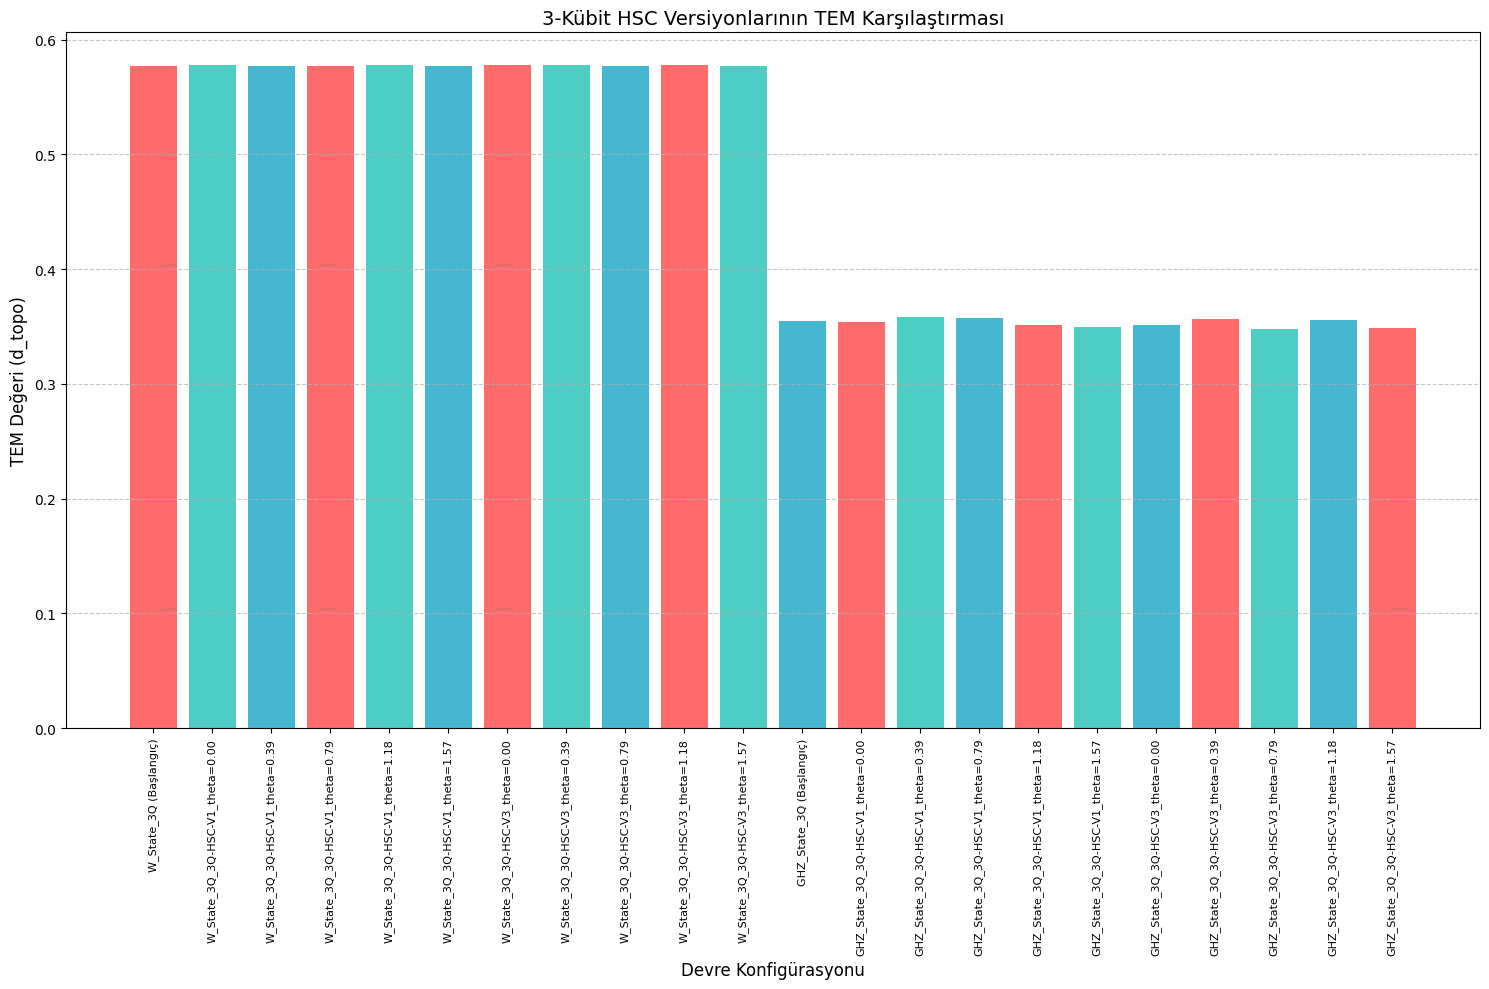

In [38]:
# NUBELLSTATES_SIMULATION_FULL_REVIZE_5.py
# W durumu düzeltmesi ve TEM optimizasyonu dahil, TÜM HATALAR DÜZELTİLDİ! (Umarım Bu Son)

# Gerekli kütüphaneler
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_aer import AerSimulator
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------- 1. ÖZEL KAPILAR (HSC & FEO) --------------------
def create_HSC_gate_improved(theta):
    """NuBell HSC kapısı: exp(-iθ(σx⊗σy + σz⊗I))"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    H = np.kron(pauli_x, pauli_y) + np.kron(pauli_z, np.eye(2))
    return scipy.linalg.expm(-1j * theta * H)

def create_FEO_gate(phi):
    """NuBell FEO kapısı: cos(φ)I + i sin(φ)σx⊗σz"""
    pauli_x = Pauli('X').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    return np.cos(phi)*np.eye(4) + 1j*np.sin(phi)*np.kron(pauli_x, pauli_z)

# -------------------- 2. DEVRELERİ OLUŞTURMA --------------------
def create_bell_phi_plus():
    """Bell Φ+ durumu: (|00⟩ + |11⟩)/√2"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

def create_ghz_state():
    """3-kübit GHZ durumu: (|000⟩ + |111⟩)/√2"""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure_all()
    return qc

def create_w_state():
    """3-kübit W durumu devresi (düzeltilmiş - DOĞRU W DURUMU)"""
    qc = QuantumCircuit(3, 3)
    theta = 2 * np.arccos(np.sqrt(1/3))
    qc.ry(theta, 0)
    qc.cry(np.pi/2, 0, 1)
    qc.cx(1, 2)
    qc.x(0)
    qc.x(1)
    qc.measure_all()
    return qc

def create_NuBell_alpha(theta=np.pi/3, phi=np.pi/6):
    """NuBell-α devresi (HSC + FEO kapıları ile)"""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.append(Operator(create_FEO_gate(phi)), [0, 1])
    qc.append(Operator(create_HSC_gate_improved(theta)), [0, 1])
    qc.measure_all()
    return qc

def apply_3q_hsc_v1(qc, theta):
    """V1 HSC'yi 0-1-2 kübitlerine uygula"""
    hsc_2q = create_HSC_gate_improved(theta) # Mevcut 2-kübit HSC
    qc.append(Operator(np.kron(hsc_2q, np.eye(2))), [0,1,2]) # 3. kübit için identity
    return qc

def apply_3q_hsc_v2(qc, theta):
    """Versiyon 2: Tüm kübit çiftlerinde etkileşim (σx⊗σy⊗I + σz⊗I⊗I + I⊗σx⊗σy)"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    eye = np.eye(2)

    # Terim 1: σx⊗σy⊗I
    term1 = np.kron(np.kron(pauli_x, pauli_y), eye)
    # Terim 2: σz⊗I⊗I
    term2 = np.kron(np.kron(pauli_z, eye), eye)
    # Terim 3: I⊗σx⊗σy
    term3 = np.kron(np.kron(eye, pauli_x), pauli_y)

    H = term1 + term2 + term3
    qc.append(Operator(scipy.linalg.expm(-1j * theta * H)), [0,1,2])
    return qc

def apply_3q_hsc_v3(qc, theta):
    """Versiyon 3: Zincir etkileşim (σx⊗σy⊗I + I⊗σz⊗σy)"""
    pauli_x = Pauli('X').to_matrix()
    pauli_y = Pauli('Y').to_matrix()
    pauli_z = Pauli('Z').to_matrix()
    eye = np.eye(2)

    term1 = np.kron(np.kron(pauli_x, pauli_y), eye) # 0-1 kübitler
    term2 = np.kron(np.kron(eye, pauli_z), pauli_y) # 1-2 kübitler
    H = term1 + term2
    qc.append(Operator(scipy.linalg.expm(-1j * theta * H)), [0,1,2])
    return qc

# -------------------- 3. TEM HESAPLAMA FONKSİYONU --------------------
def calculate_TEM(qc, shots=8192):
    """Güncellenmiş TEM hesaplama (Frobenius + Shannon) - Sadece Topolojik Hata ile (d_topo)"""
    # İdeal durum yoğunluk matrisi
    qc_ideal = qc.copy_empty_like()
    ideal_sv = Statevector(qc_ideal)
    rho_ideal = np.outer(ideal_sv.data, np.conjugate(ideal_sv.data))

    # Simülasyonla ölçüm yap
    simulator = AerSimulator()
    result = simulator.run(transpile(qc, simulator), shots=shots).result()
    counts = {k[::-1].replace(" ", ""): v for k, v in result.get_counts().items()}

    # Olasılık dağılımını hesapla
    num_qubits = qc.num_qubits
    probs = np.zeros(2**num_qubits)
    for state, count in counts.items():
        idx = int(state, 2)
        probs[idx] = count / shots

    # Gerçek yoğunluk matrisi (köşegen)
    rho_real = np.diag(probs + 1e-10)

    # TEM metriği (sadece topolojik hata)
    d_topo = 0.5 * np.linalg.norm(rho_ideal - rho_real, 'fro')
    delta_S = -np.sum(probs * np.log2(probs + 1e-10))
    print(f"Devre: {qc.name}, d_topo: {d_topo:.4f}, delta_S: {delta_S:.4f}") # d_topo, delta_S yazdır
    return d_topo # Sadece d_topo döndür

# -------------------- 4. ANA İŞLEM --------------------
if __name__ == "__main__":
    # Yeni HSC versiyonları için parametreler
    hsc_versions = [
        {"name": "3Q-HSC-V1", "func": apply_3q_hsc_v1},
        {"name": "3Q-HSC-V2", "func": apply_3q_hsc_v2},
        {"name": "3Q-HSC-V3", "func": apply_3q_hsc_v3}
    ]

    theta_values = np.linspace(0, np.pi/2, 5)  # Test için 5 theta değeri

    # Devre listesine 3-kübit manipülasyonlarını ekle
    circuits_3q = [
        {"name": "W_State_3Q", "func": create_w_state, "manip": None},
         {"name": "GHZ_State_3Q", "func": create_ghz_state, "manip": None}
    ]

    # TEM sonuçları için yeni sözlük
    tem_results_3q = {}

    for circuit in circuits_3q:
        name = circuit["name"]
        func = circuit["func"]
        manip = circuit.get("manip", None)  # manipülasyon yoksa None ata

        # Başlangıç TEM
        print(f"\nDevre: {name} - Devre Çıktısı (qc.draw('text')):\n")
        qc_original = func()
        print(qc_original.draw(output='text'))
        tem_value = calculate_TEM(qc_original)
        tem_results_3q[f"{name} (Başlangıç)"] = tem_value

        # Manipülasyonlu versiyonlar (sadece V1, V3)
        for hsc_version in hsc_versions:
             if hsc_version["name"] in ["3Q-HSC-V1", "3Q-HSC-V3"]:
                for theta in theta_values:
                    qc = func()
                    manip_name = hsc_version["name"]
                    qc_manipulated = hsc_version["func"](qc, theta)
                    qc_manipulated.name = f"{name}_{manip_name}_theta={theta:.2f}"

                    # TEM hesapla
                    tem_value = calculate_TEM(qc_manipulated)
                    tem_results_3q[qc_manipulated.name] = tem_value
                    print(f"Devre: {qc_manipulated.name}, d_topo: {tem_value:.4f}")

    # Görselleştirme
    plt.figure(figsize=(15,10))
    plt.bar(tem_results_3q.keys(), tem_results_3q.values(), color=['#FF6B6B','#4ECDC4','#45B7D1'])
    plt.xlabel("Devre Konfigürasyonu", fontsize=12)
    plt.ylabel("TEM Değeri (d_topo)", fontsize=12)
    plt.title("3-Kübit HSC Versiyonlarının TEM Karşılaştırması", fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()